In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj

PROCESSED_DIR = 'processed'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

**load annotations in different directions**

In [12]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}

**load directions for linear models**

In [13]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))
directions = {}

# no key for ethnicity (also missing smiling/earrings?)
renaming = {
    'age': 'A',
    'facial-hair': 'B',
    'skin-color': 'C',
    'gender': 'G',
    'hair-length': 'H',
    'makeup': 'M',
}
for k in renaming:
    linear_model = pkl.load(open(oj(DIRECTIONS_DIR, f'{renaming[k]}_W.pkl'), 'rb'))
    directions[k] = linear_model.coef_.flatten() #.reshape(-1, 1)
    print(k, type(linear_model))

age <class 'sklearn.linear_model._ridge.Ridge'>
facial-hair <class 'sklearn.svm._classes.LinearSVC'>
skin-color <class 'sklearn.linear_model._ridge.Ridge'>
gender <class 'sklearn.svm._classes.LinearSVC'>
hair-length <class 'sklearn.linear_model._ridge.Ridge'>
makeup <class 'sklearn.svm._classes.LinearSVC'>


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# analyze metrics along these axes

In [14]:
# note thes axes are not orthogonalized yet
np.dot(directions['age'], directions['skin-color'])

0.058273845411123446

**project everything onto its corresponding linear model**

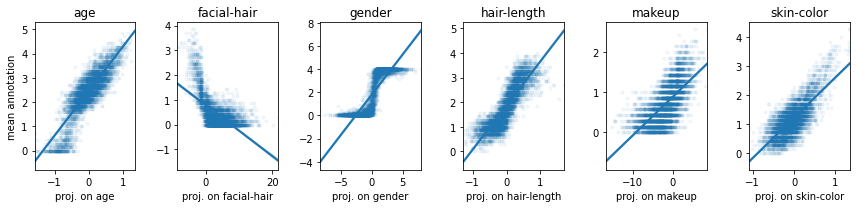

In [15]:
attrs = list(sorted(renaming.keys()))
R = 1
C = len(attrs)
plt.figure(figsize=(C * 2, 3))
for i, attr in enumerate(attrs):
    attr_to_proj = attr
    projections = latents @ directions[attr]
    mean_attr = annotations_dict[attr].mean(axis=1)
    
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    sns.regplot(projections, mean_attr, marker='.', scatter_kws={'alpha': 0.05})
    
    if i == 0:
        plt.ylabel('mean annotation')
    plt.xlabel(f'proj. on {attr_to_proj}')
#     plt.xlabel('projection onto linear direction')
#     plt.plot(projections, mean_attr, '.')
plt.tight_layout()

**project everything onto a single linear model**

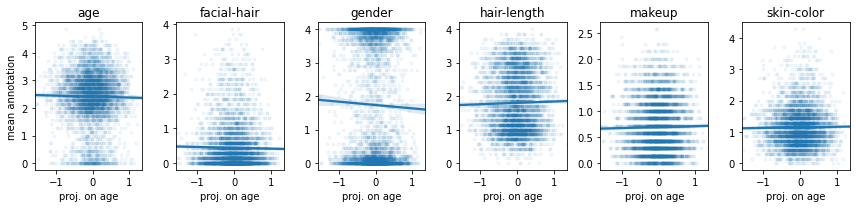

In [20]:
attrs = list(sorted(renaming.keys()))
attr_to_proj = 'age'
R = 1
C = len(attrs)
plt.figure(figsize=(C * 2, 3))
for i, attr in enumerate(attrs):
    projections = latents @ directions[attr_to_proj]
    mean_attr = annotations_dict[attr].mean(axis=1)
    
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    sns.regplot(projections, mean_attr, marker='.', scatter_kws={'alpha': 0.05})
    
    if i == 0:
        plt.ylabel('mean annotation')
    plt.xlabel(f'proj. on {attr_to_proj}')
#     plt.xlabel('projection onto linear direction')
#     plt.plot(projections, mean_attr, '.')
plt.tight_layout()

**refit linear models**

In [26]:
import sklearn

In [22]:
X.shape

(5000, 512)

In [25]:
attr = 'age'
X = latents
y = annotations_dict[attr].mean(axis=1)
y = (y - y.mean()) / (y.std())

In [32]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [33]:
m = sklearn.linear_mod

(3500, 512)